In [41]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle, plotTrajectoriesFile, AdvectionRK4,ErrorCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.special import entr

In [42]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [43]:
class MPParticle(JITParticle):
    Kzf = Variable('Kzf', initial =  1.0) 
class MPParticle2(JITParticle):
    Kzf = Variable('Kzf', initial =  0.0) 

In [44]:
def tu_mix(particle,fieldset,time):
    if particle.lat+0.5 > bath: #Only calculate gradient of diffusion for particles deeper than 0.6 otherwise OP will check for particles outside the domain and remove it.
        Kzdz = 0
    else: 
        Kzdz = 2*(fieldset.Kz[time,particle.depth,particle.lat+0.5, particle.lon]-fieldset.Kz[time,particle.depth, particle.lat, particle.lon]) #forward difference 
    dgrad = Kzdz * particle.dt * particle.Kzf
    if particle.lat+0.5*dgrad > 0.5:
        kk = fieldset.Kz[time,particle.depth, particle.lat+0.5*dgrad, particle.lon] #Vertical diffusivity SSC  #
    else:
        kk = fieldset.Kz[time,particle.depth, 0.5, particle.lon] #Vertical diffusivity SSC  #
    Kx = 20.5
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    bath= 109.73707
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.lat > bath: #randomly in the water column
        particle.lat = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.lat +dgrad < 0:
            particle.lat = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.lat += d_random + dgrad 

In [45]:
Dat = pd.read_csv('ubcSSg3DwGridFields1hV19-05_9244_b1de_6bbd.csv')
depth=np.array(Dat.depth)[1:].astype('float32')
Kz_col=np.array(Dat.vert_eddy_diff)[1:].astype('float32')

In [46]:
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)
dep2= np.linspace(0., depth[-1], dim, dtype=np.float32)
#lon_g, depth_g = np.meshgrid(lon,dep2)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=depth)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=depth)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col
Kz = Field('Kz', Kz_data, grid=U.grid)

In [47]:
fieldset = FieldSet(U, V)
fieldset.add_field(Kz)

In [48]:
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))

In [49]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, lat=depth_g)
    pset2 = ParticleSet(fieldset, pclass=MPParticle2, lon=lon_g, lat=depth_g)
    output_file = pset.ParticleFile(name='Output.nc', outputdt=50)
    output_file2 = pset2.ParticleFile(name='Output2.nc', outputdt=50)
    KE=AdvectionRK4 + pset.Kernel(tu_mix)
    pset.execute(KE , runtime=5000, dt=5, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    output_file.export()  # export the trajectory data to a netcdf file
    pset2.execute(KE , runtime=5000, dt=5, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    output_file2.export()  # export the trajectory data to a netcdf file

In [50]:
run_turb_test(lon_g,depth_g)

INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/libb46fbeb8ccab32c35f78de55213884c3_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib706ac4aeacbae4e44b1b5cc77882dd24_0.so


In [51]:
dat = xr.load_dataset('Output.nc')
dat2 = xr.load_dataset('Output2.nc')

Text(0, 0.5, 'Depth (m)')

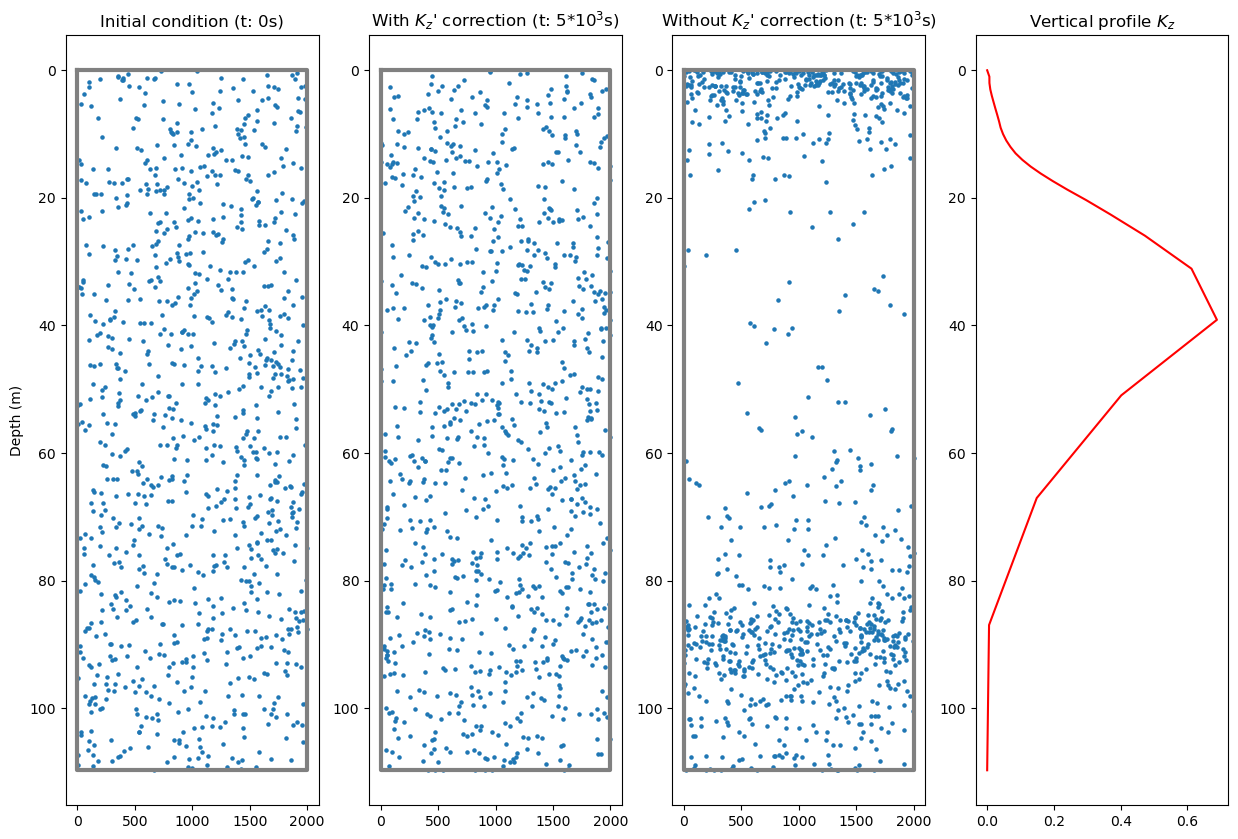

In [52]:
box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
fig,axs=plt.subplots(1,4,figsize=(15,10))
axs[0].scatter(dat.lon[:,0],dat.lat[:,0],s=5)
#ax2 = axs[2].twiny()
#ax2.plot(Kz_col,depth,c='r')
axs[3].plot(Kz_col,depth,c='r')
axs[3].set_title('Vertical profile $K_z$')
axs[3].invert_yaxis()
axs[0].plot(box[0],box[1],c='grey',linewidth=3)
axs[1].plot(box[0],box[1],c='grey',linewidth=3)
axs[2].plot(box[0],box[1],c='grey',linewidth=3)
axs[0].invert_yaxis()
axs[0].set_title('Initial condition (t: 0s)')
axs[1].scatter(dat.lon[:,-1],dat.lat[:,-1],s=5)
axs[1].invert_yaxis()
axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
axs[2].scatter(dat2.lon[:,-1],dat2.lat[:,-1],s=5)
axs[2].invert_yaxis()
axs[2].set_title("Without $K_z$' correction (t: 5*$10^3$s)")
axs[0].set_ylabel('Depth (m)')

In [53]:
def entropy(data, bins=100):
    """
        Calculate entropy of multiple varibles (discrete and continous).
        X is a 2d-array, each column is a variable.
    """
    hist = np.histogramdd(data, bins=bins)[0]
    prob = hist/len(data)
    prob[prob == 0] = 1
    log_prob = np.log2(prob)
    

    return -np.sum(np.multiply(prob, log_prob))

In [54]:
def no_nan(x,y):
    no_nan=[]
    no_nan1=[]
    for i,xi in enumerate(x):
        if np.isnan(xi) == False:
            no_nan.append(xi) 
            no_nan1.append(y[i]) 
    return no_nan,no_nan1

d0,l0=no_nan(dat2.lat[:,0],dat2.lon[:,0])
e0=entropy([d0,l0])

In [55]:
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [56]:
def run_n_test(n):
    e1,e2=[],[]
    for i in range(n):
        lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
        depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))
        run_turb_test(lon_g,depth_g)
        dat = xr.load_dataset('Output.nc')
        dat2 = xr.load_dataset('Output2.nc')
        d0,l0=no_nan(dat2.lat[:,0],dat2.lon[:,0])
        e0=entropy([d0,l0])
        d2,l2=no_nan(dat2.lat[:,-1],dat2.lon[:,-1])
        e2.append(entropy([d2,l2])-e0)
        d1,l1=no_nan(dat.lat[:,-1],dat.lon[:,-1])
        e1.append(entropy([d1,l1])-e0)
    m1=np.mean(e1)
    sd1=np.std(e1)/np.sqrt(n)
    m2=np.mean(e2)
    sd2=np.std(e2)/np.sqrt(n)
    return m1,sd1,m2,sd2

In [57]:
blockPrint()
m1,sd1,m2,sd2=run_n_test(10)
enablePrint()

CTEs = [m1, m2]
error = [sd1, sd2]

INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib60f69f3e96675a07db0fca5e879ebcc1_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib81301f3136b65e4b3b795ea99de51b85_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/libf06d0049aef02baf1a813dc15cc7d849_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/libdbd01033242caadffd3214d3a13c3e9f_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib396491c6e2bd699627b0feb1d6589bdb_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/liba74b85adb57df18335edf035bb936aa0_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/_

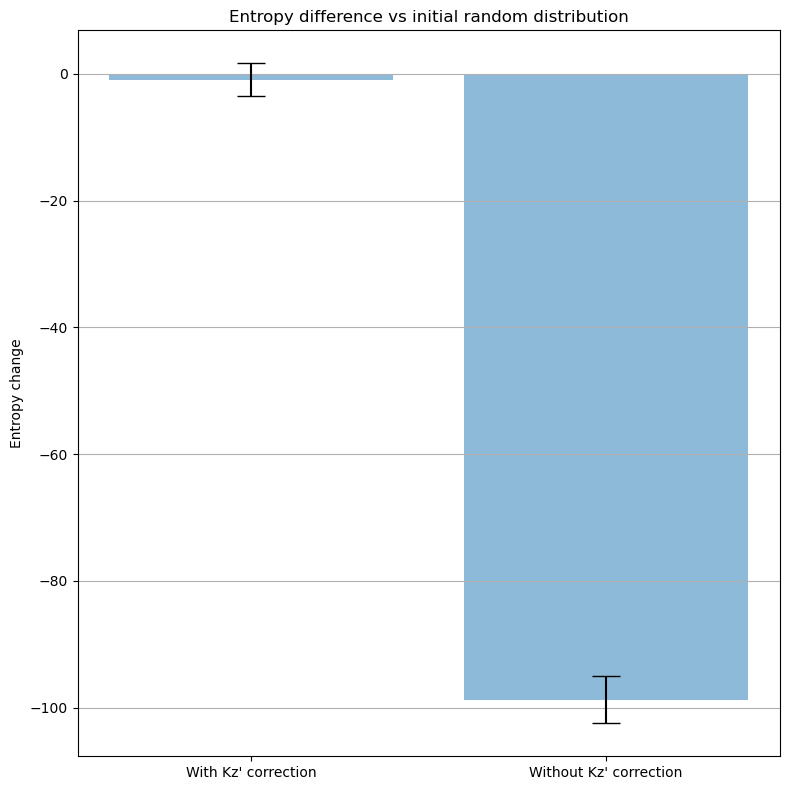

In [58]:
# Build the plot
x_pos=np.arange(2)
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Entropy change')
ax.set_xticks(x_pos)
ax.set_xticklabels(["With Kz' correction","Without Kz' correction"])
ax.set_title('Entropy difference vs initial random distribution')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

In [59]:
d2,l2=no_nan(dat2.lat[:,-1],dat2.lon[:,-1])
entropy([d2,l2])-e0

-100.84392025452621

In [60]:
d1,l1=no_nan(dat.lat[:,-1],dat.lon[:,-1])
entropy([d1,l1])-e0

12.377443751081728